# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [104]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

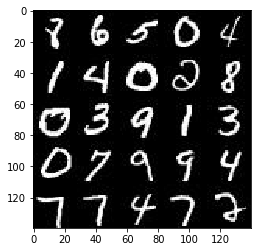

In [105]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

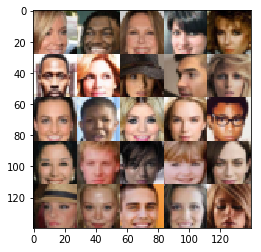

In [106]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [107]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0


/Users/shakiralharthi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [108]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width,image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32,[None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32, name= 'lr')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [109]:
#set alpha 

alpha = .2

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [141]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    #print(images.shape)
    with tf.variable_scope('discriminator',reuse=reuse):
        x = tf.layers.conv2d(inputs=images, filters = 32 , kernel_size= 5, strides= 2 ,  padding='same',activation= None)
        relul = tf.maximum(x * alpha, x)
        
   
        #now shape is 14*14*32
        
        x2 = tf.layers.conv2d(relul, filters = 64, kernel_size= 5, strides=2, padding = 'same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training= True)
        relul2 = tf.maximum(x2 * alpha, x2)
        #relul2 = tf.layers.dropout(relul2,rate=.8)
        
        # Now shape is 7*7*64

        x3 =  tf.layers.conv2d(relul2, filters = 128, kernel_size= 5, strides=2, padding = 'same',activation=None)
        x3 =  tf.layers.batch_normalization(x3, training= True)
        relul3 = tf.maximum(x3 * alpha, x3)
        #relul3 = tf.layers.dropout(relul3,rate=.8)
        
        
       
        #print('relul3  =',relul3.shape)
        

        
        flat = tf.reshape(relul3, (-1, 4*4*128))
        
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [113]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
   
    # TODO: Implement Function

    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse = reuse):
        
        x1= tf.layers.dense(z,2*2*1024)
        #print(x1.shape)
        x1= tf.reshape(z, (-1, 2,2,1024))
        x1= tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        #print (x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 512,5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 256,5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        
        
        

        
        #print(out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x
        
        #print(logits.shape, 'logits shape')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [114]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logit_real = discriminator(input_real, reuse= False)
    d_output_fake, d_logit_fake = discriminator(g_output, reuse= True)
    
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels=tf.zeros_like(d_output_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake,labels = tf.ones_like(d_output_fake)))
    
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [115]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [122]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-.5, .5, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [142]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
  

    
    #print(data_shape)
    step = 0
    real_input,z_input,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #print(batch_images.shape)
                step += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-.5,.5 , size=(batch_size, z_dim))

                #print('batch_z shape',batch_z.shape)
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_train_opt, feed_dict = {z_input: batch_z, real_input: batch_images})

                if step % 90 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
               
                    show_generator_output(sess, 512, z_input, data_shape[3], data_image_mode)
    
                   
                


### Below I will try the model on multiple different hyperparameter values on the MNIST images 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 4.8456... Generator Loss: 0.0127


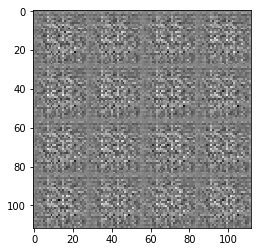

Epoch 1/3... Discriminator Loss: 2.1635... Generator Loss: 0.1884


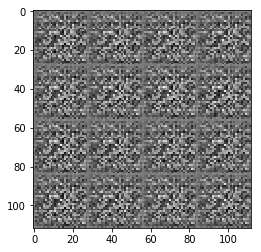

Epoch 1/3... Discriminator Loss: 1.4470... Generator Loss: 0.4051


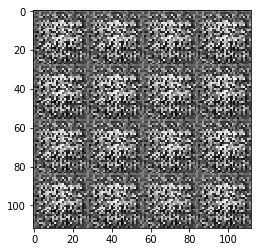

Epoch 1/3... Discriminator Loss: 1.1887... Generator Loss: 0.7038


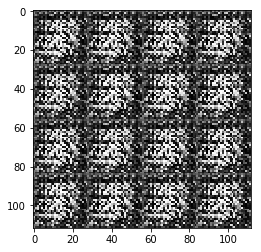

Epoch 1/3... Discriminator Loss: 0.9263... Generator Loss: 0.9077


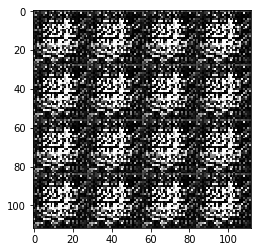

Epoch 1/3... Discriminator Loss: 1.2723... Generator Loss: 0.8783


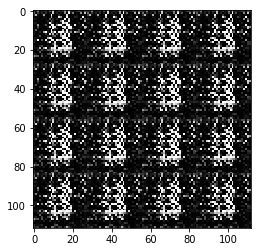

Epoch 1/3... Discriminator Loss: 0.8146... Generator Loss: 1.0887


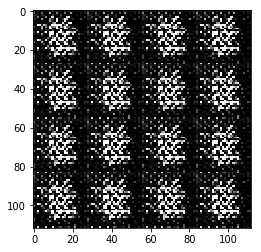

Epoch 1/3... Discriminator Loss: 0.7756... Generator Loss: 1.0613


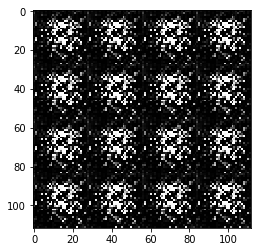

Epoch 1/3... Discriminator Loss: 0.9586... Generator Loss: 0.9960


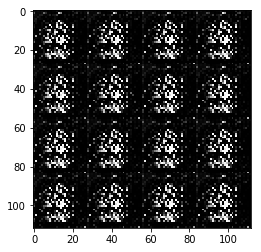

Epoch 1/3... Discriminator Loss: 0.9379... Generator Loss: 1.2021


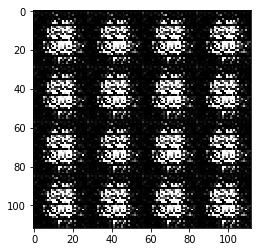

Epoch 1/3... Discriminator Loss: 0.7609... Generator Loss: 1.1621


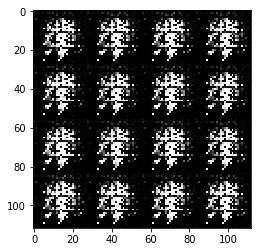

Epoch 1/3... Discriminator Loss: 0.8312... Generator Loss: 0.9976


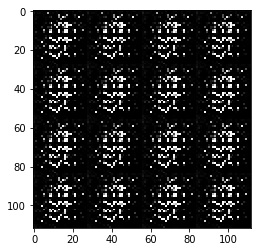

Epoch 2/3... Discriminator Loss: 0.6578... Generator Loss: 1.2964


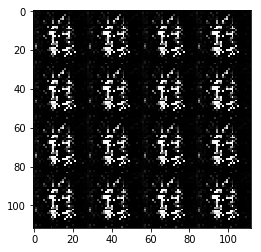

Epoch 2/3... Discriminator Loss: 0.4373... Generator Loss: 1.6830


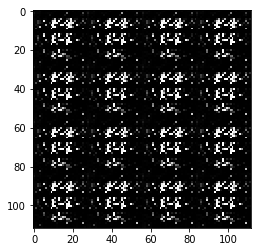

Epoch 2/3... Discriminator Loss: 0.4297... Generator Loss: 1.8060


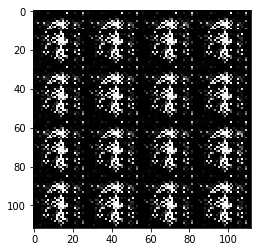

Epoch 2/3... Discriminator Loss: 0.4587... Generator Loss: 1.5202


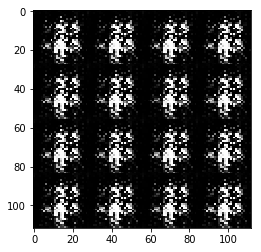

Epoch 2/3... Discriminator Loss: 0.2156... Generator Loss: 2.4392


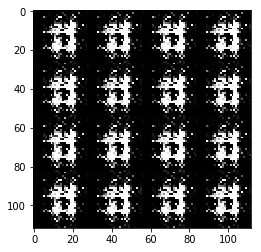

Epoch 2/3... Discriminator Loss: 0.2117... Generator Loss: 2.3788


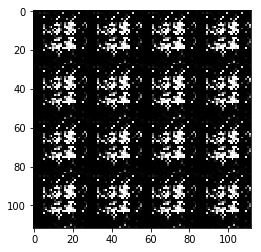

Epoch 2/3... Discriminator Loss: 0.6900... Generator Loss: 1.0257


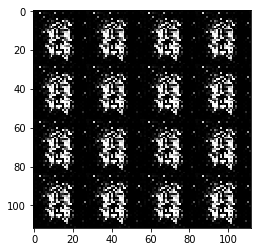

Epoch 2/3... Discriminator Loss: 0.3572... Generator Loss: 1.7977


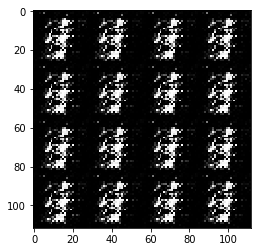

Epoch 2/3... Discriminator Loss: 0.5801... Generator Loss: 1.4291


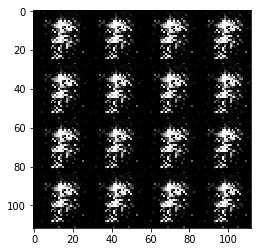

Epoch 2/3... Discriminator Loss: 0.2263... Generator Loss: 2.3495


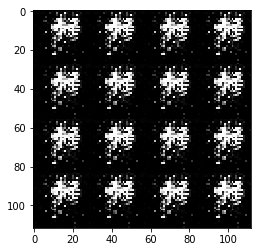

Epoch 2/3... Discriminator Loss: 0.5017... Generator Loss: 1.4805


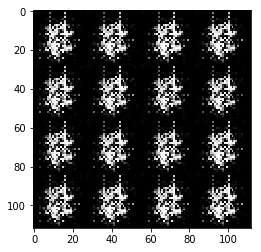

Epoch 2/3... Discriminator Loss: 0.2776... Generator Loss: 2.0380


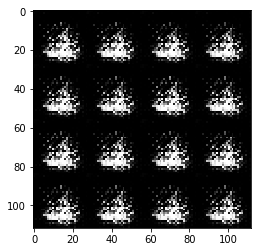

Epoch 2/3... Discriminator Loss: 0.1302... Generator Loss: 2.6467


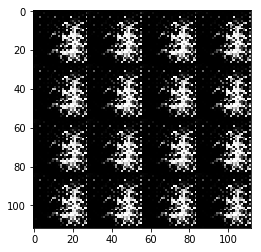

Epoch 3/3... Discriminator Loss: 0.1403... Generator Loss: 2.3698


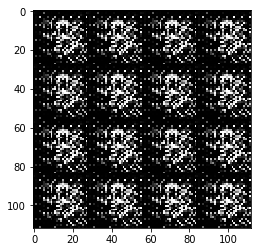

Epoch 3/3... Discriminator Loss: 0.1112... Generator Loss: 2.7575


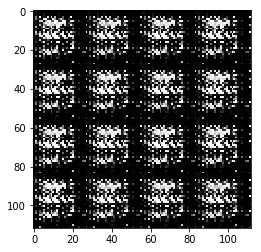

Epoch 3/3... Discriminator Loss: 0.1671... Generator Loss: 2.3139


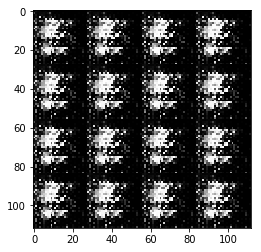

Epoch 3/3... Discriminator Loss: 0.1826... Generator Loss: 2.2372


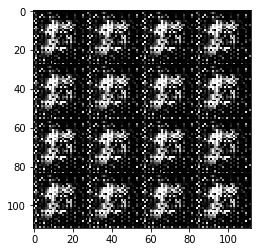

Epoch 3/3... Discriminator Loss: 0.1863... Generator Loss: 2.2974


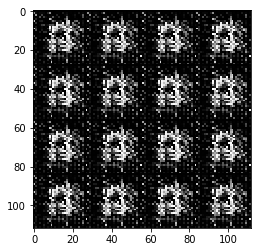

Epoch 3/3... Discriminator Loss: 0.1807... Generator Loss: 2.4494


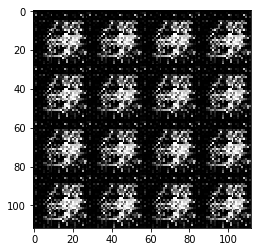

Epoch 3/3... Discriminator Loss: 0.0962... Generator Loss: 2.8779


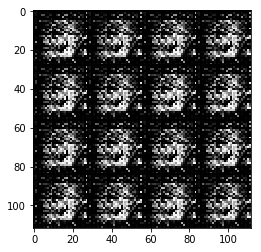

Epoch 3/3... Discriminator Loss: 0.0775... Generator Loss: 3.3679


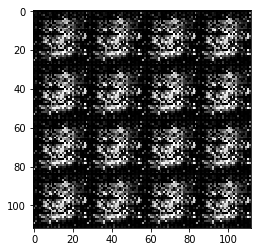

Epoch 3/3... Discriminator Loss: 0.1060... Generator Loss: 2.7401


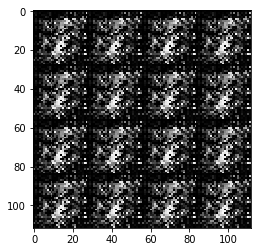

Epoch 3/3... Discriminator Loss: 0.1453... Generator Loss: 2.3169


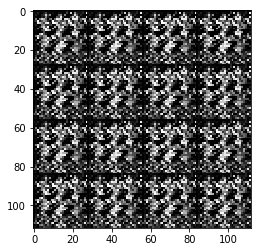

Epoch 3/3... Discriminator Loss: 0.1541... Generator Loss: 2.1264


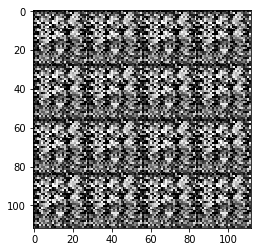

Epoch 3/3... Discriminator Loss: 0.2396... Generator Loss: 1.6929


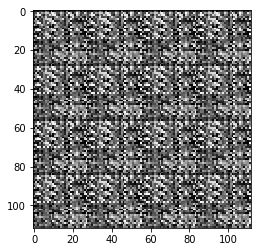

finsihed


In [127]:
batch_size =160
z_dim = 128
learning_rate = 0.00005
beta1 = .5
alpha= .3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

Epoch 1/3... Discriminator Loss: 2.1277... Generator Loss: 0.1847


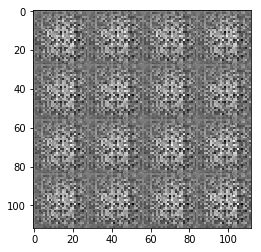

Epoch 1/3... Discriminator Loss: 0.4366... Generator Loss: 1.4987


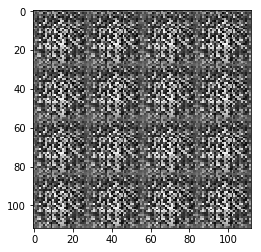

Epoch 1/3... Discriminator Loss: 0.3527... Generator Loss: 1.5210


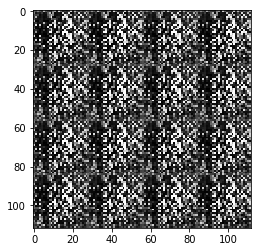

Epoch 1/3... Discriminator Loss: 0.2433... Generator Loss: 2.2662


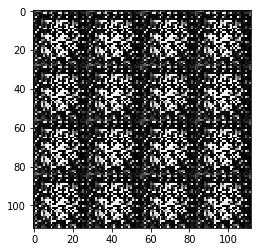

Epoch 1/3... Discriminator Loss: 0.2875... Generator Loss: 1.9841


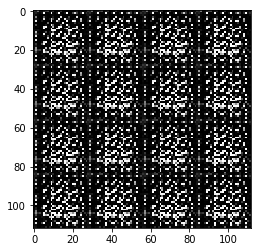

Epoch 1/3... Discriminator Loss: 0.1010... Generator Loss: 3.0715


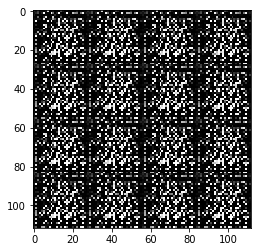

Epoch 1/3... Discriminator Loss: 0.2242... Generator Loss: 2.0155


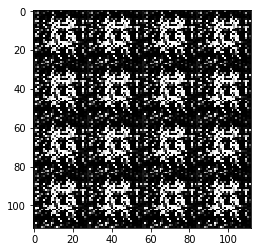

Epoch 1/3... Discriminator Loss: 0.2610... Generator Loss: 2.2627


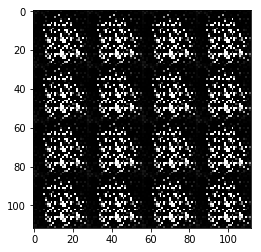

Epoch 1/3... Discriminator Loss: 0.1216... Generator Loss: 3.1276


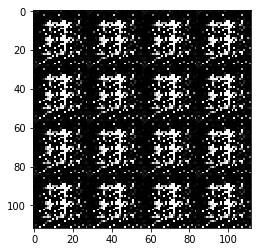

Epoch 1/3... Discriminator Loss: 0.3328... Generator Loss: 2.0169


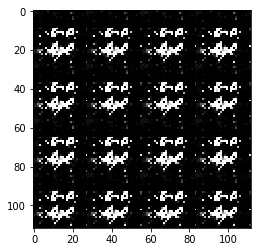

Epoch 1/3... Discriminator Loss: 0.3853... Generator Loss: 1.6573


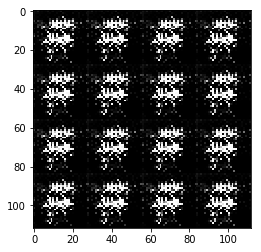

Epoch 1/3... Discriminator Loss: 0.2735... Generator Loss: 2.3240


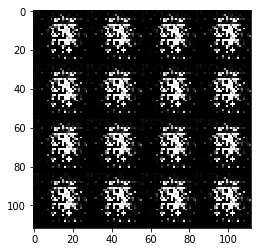

Epoch 2/3... Discriminator Loss: 0.1575... Generator Loss: 2.5828


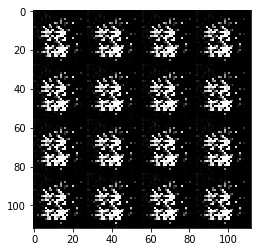

Epoch 2/3... Discriminator Loss: 0.0963... Generator Loss: 2.9911


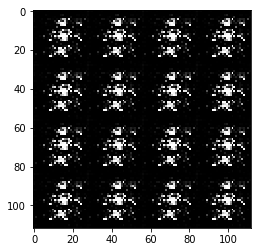

Epoch 2/3... Discriminator Loss: 0.1404... Generator Loss: 2.6364


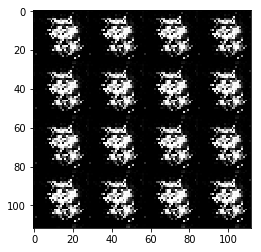

Epoch 2/3... Discriminator Loss: 0.1302... Generator Loss: 2.8152


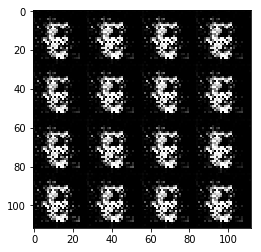

Epoch 2/3... Discriminator Loss: 0.0416... Generator Loss: 3.6855


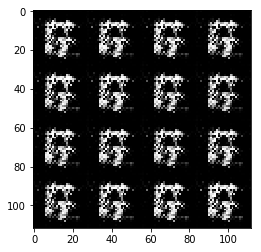

Epoch 2/3... Discriminator Loss: 0.0768... Generator Loss: 3.1092


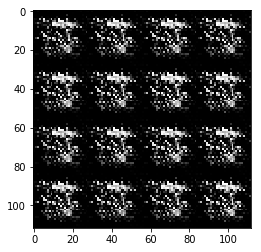

Epoch 2/3... Discriminator Loss: 0.0611... Generator Loss: 3.3987


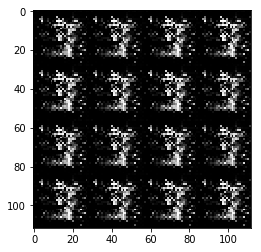

Epoch 2/3... Discriminator Loss: 0.0349... Generator Loss: 3.7883


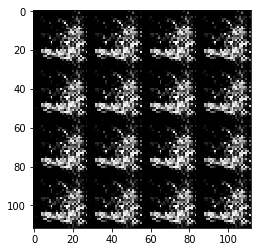

Epoch 2/3... Discriminator Loss: 0.0240... Generator Loss: 4.0570


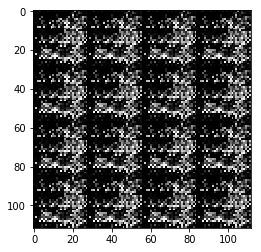

Epoch 2/3... Discriminator Loss: 0.0309... Generator Loss: 3.8990


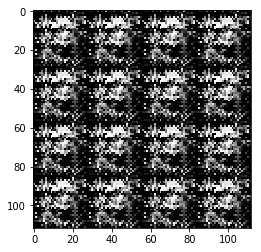

Epoch 2/3... Discriminator Loss: 0.0715... Generator Loss: 3.0446


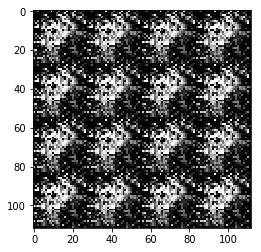

Epoch 2/3... Discriminator Loss: 0.0604... Generator Loss: 3.3695


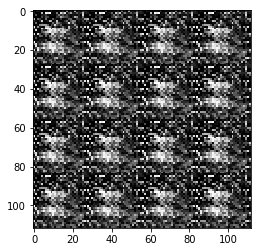

Epoch 2/3... Discriminator Loss: 0.1520... Generator Loss: 2.0817


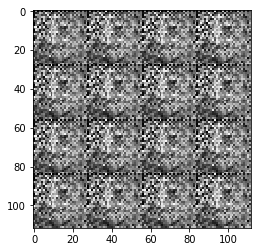

Epoch 3/3... Discriminator Loss: 2.5869... Generator Loss: 0.0898


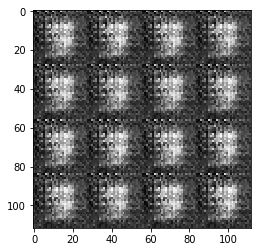

Epoch 3/3... Discriminator Loss: 0.4187... Generator Loss: 2.3835


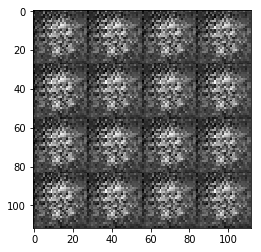

Epoch 3/3... Discriminator Loss: 0.6140... Generator Loss: 4.0309


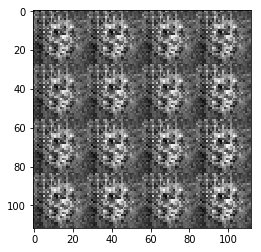

Epoch 3/3... Discriminator Loss: 1.7852... Generator Loss: 0.2259


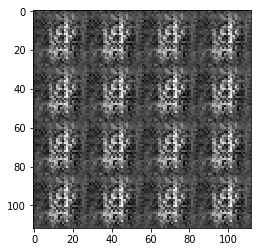

Epoch 3/3... Discriminator Loss: 0.2073... Generator Loss: 2.4665


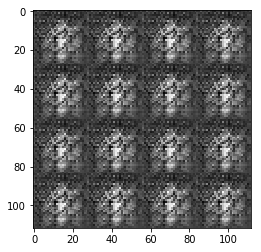

Epoch 3/3... Discriminator Loss: 0.3182... Generator Loss: 2.7030


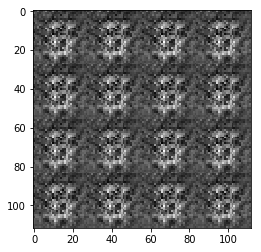

Epoch 3/3... Discriminator Loss: 0.3664... Generator Loss: 1.8556


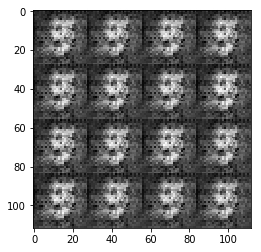

Epoch 3/3... Discriminator Loss: 0.4446... Generator Loss: 1.5181


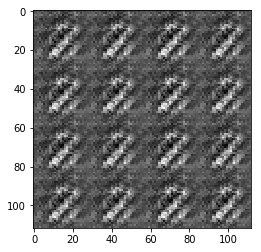

Epoch 3/3... Discriminator Loss: 0.4122... Generator Loss: 1.6137


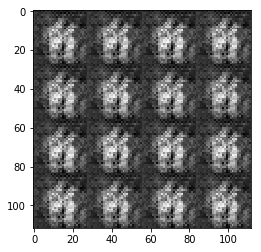

Epoch 3/3... Discriminator Loss: 0.4510... Generator Loss: 1.6342


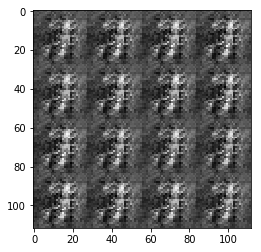

Epoch 3/3... Discriminator Loss: 0.3955... Generator Loss: 1.6987


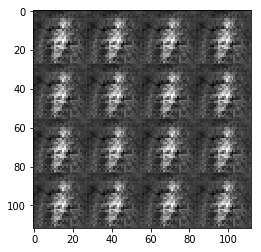

Epoch 3/3... Discriminator Loss: 0.3470... Generator Loss: 1.9679


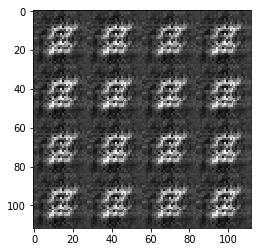

finsihed


In [128]:
batch_size =160
z_dim = 128
learning_rate = 0.0001
beta1 = .5
alpha= .3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

Epoch 1/3... Discriminator Loss: 2.1278... Generator Loss: 0.2006


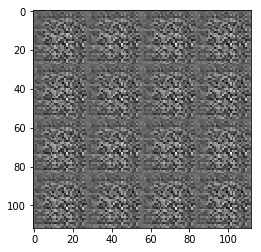

Epoch 1/3... Discriminator Loss: 0.6342... Generator Loss: 1.1269


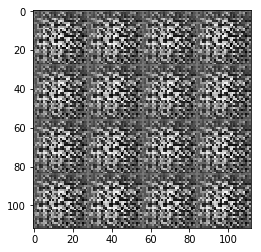

Epoch 1/3... Discriminator Loss: 0.7374... Generator Loss: 0.9682


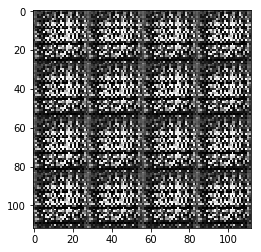

Epoch 1/3... Discriminator Loss: 0.3540... Generator Loss: 1.8842


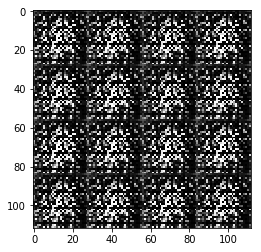

Epoch 1/3... Discriminator Loss: 0.6056... Generator Loss: 1.2383


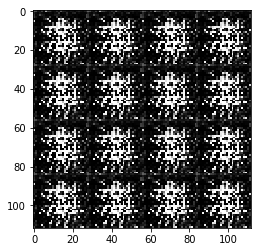

Epoch 1/3... Discriminator Loss: 0.3861... Generator Loss: 1.6338


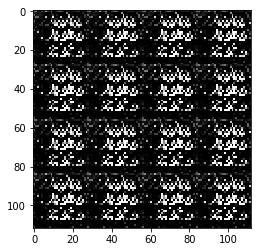

Epoch 1/3... Discriminator Loss: 0.9761... Generator Loss: 0.9069


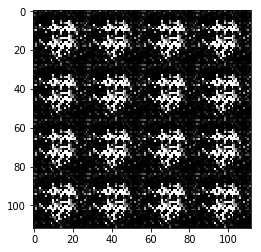

Epoch 1/3... Discriminator Loss: 0.8879... Generator Loss: 0.9654


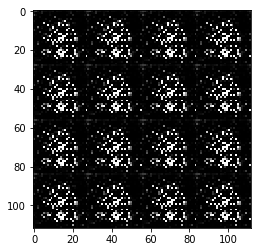

Epoch 1/3... Discriminator Loss: 0.9691... Generator Loss: 0.9790


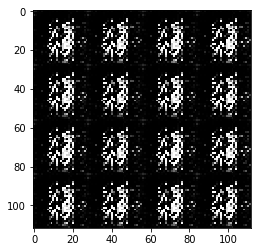

Epoch 1/3... Discriminator Loss: 0.2790... Generator Loss: 2.3239


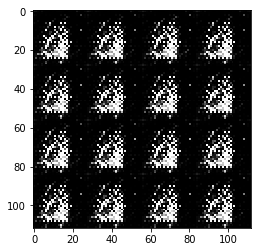

Epoch 1/3... Discriminator Loss: 0.2509... Generator Loss: 2.3521


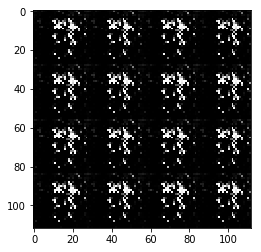

Epoch 1/3... Discriminator Loss: 0.1969... Generator Loss: 2.1145


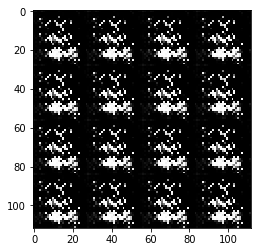

Epoch 2/3... Discriminator Loss: 0.3063... Generator Loss: 2.0163


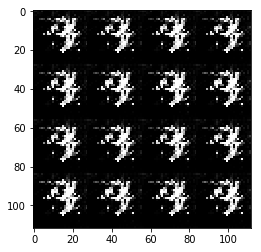

Epoch 2/3... Discriminator Loss: 0.3028... Generator Loss: 1.7522


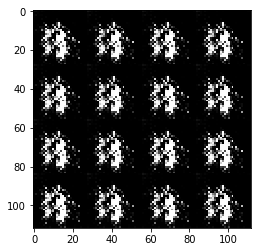

Epoch 2/3... Discriminator Loss: 0.1004... Generator Loss: 3.1574


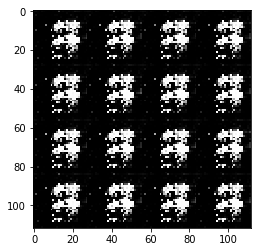

Epoch 2/3... Discriminator Loss: 0.2319... Generator Loss: 2.0357


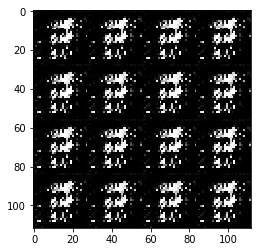

Epoch 2/3... Discriminator Loss: 0.0831... Generator Loss: 3.0528


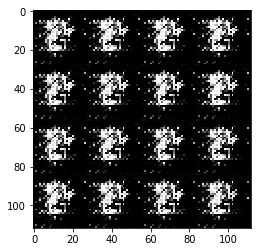

Epoch 2/3... Discriminator Loss: 0.1445... Generator Loss: 2.5445


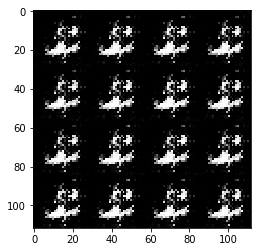

Epoch 2/3... Discriminator Loss: 0.0457... Generator Loss: 3.6598


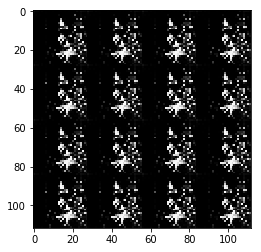

Epoch 2/3... Discriminator Loss: 0.0350... Generator Loss: 3.9560


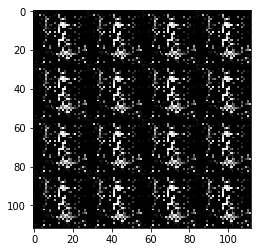

Epoch 2/3... Discriminator Loss: 0.0295... Generator Loss: 4.0516


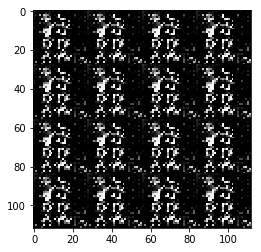

Epoch 2/3... Discriminator Loss: 0.0344... Generator Loss: 3.9972


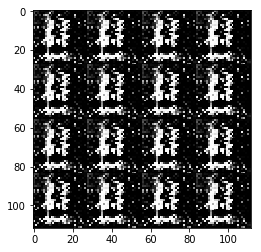

Epoch 2/3... Discriminator Loss: 0.0726... Generator Loss: 3.0613


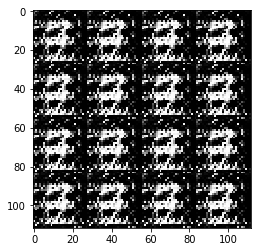

Epoch 2/3... Discriminator Loss: 0.0468... Generator Loss: 3.4775


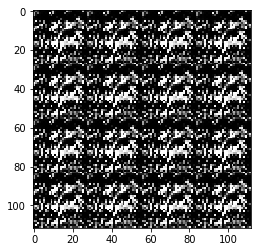

Epoch 2/3... Discriminator Loss: 0.0177... Generator Loss: 4.4268


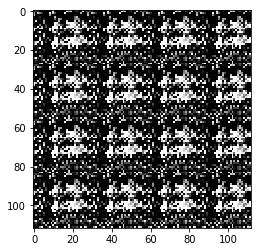

Epoch 3/3... Discriminator Loss: 0.0216... Generator Loss: 4.1540


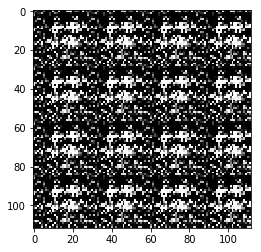

Epoch 3/3... Discriminator Loss: 0.0345... Generator Loss: 3.6693


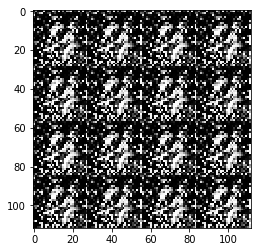

Epoch 3/3... Discriminator Loss: 0.0269... Generator Loss: 4.0007


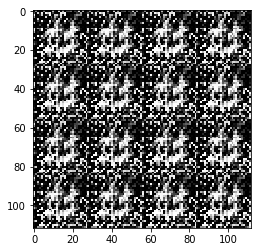

Epoch 3/3... Discriminator Loss: 0.0325... Generator Loss: 3.9035


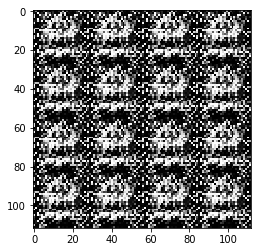

Epoch 3/3... Discriminator Loss: 0.0303... Generator Loss: 3.7524


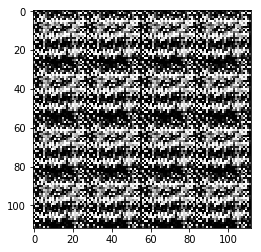

Epoch 3/3... Discriminator Loss: 0.0307... Generator Loss: 3.8434


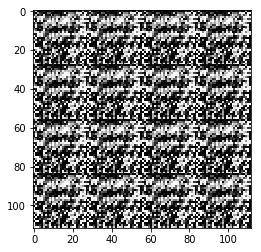

Epoch 3/3... Discriminator Loss: 0.0593... Generator Loss: 2.9632


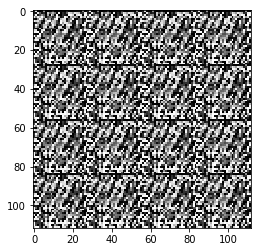

Epoch 3/3... Discriminator Loss: 0.0324... Generator Loss: 3.7463


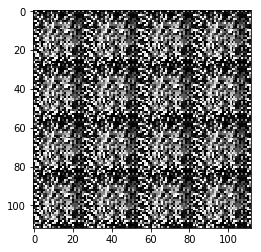

Epoch 3/3... Discriminator Loss: 0.0404... Generator Loss: 3.6366


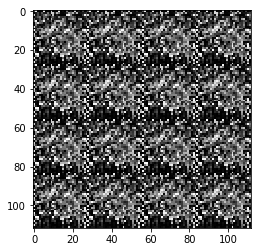

Epoch 3/3... Discriminator Loss: 0.6391... Generator Loss: 0.8177


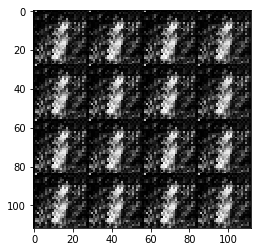

Epoch 3/3... Discriminator Loss: 0.6108... Generator Loss: 1.6335


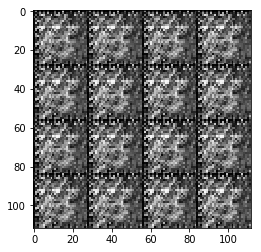

Epoch 3/3... Discriminator Loss: 0.9999... Generator Loss: 3.5986


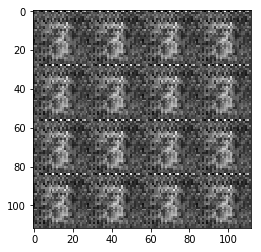

finsihed


In [129]:
batch_size =160
z_dim = 128
learning_rate = 0.0001
beta1 = .4
alpha= .3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

Epoch 1/3... Discriminator Loss: 0.4575... Generator Loss: 1.3059


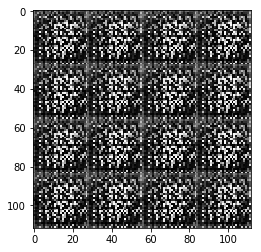

Epoch 1/3... Discriminator Loss: 1.0181... Generator Loss: 1.0043


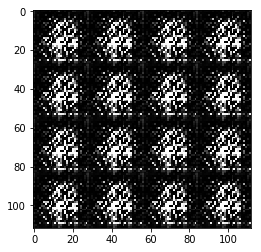

Epoch 1/3... Discriminator Loss: 0.3522... Generator Loss: 1.6218


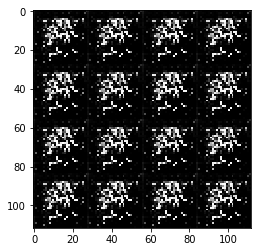

Epoch 1/3... Discriminator Loss: 0.2353... Generator Loss: 2.2852


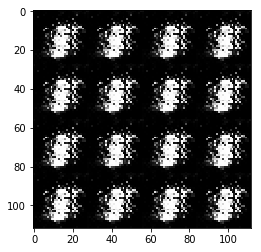

Epoch 2/3... Discriminator Loss: 0.0939... Generator Loss: 3.1495


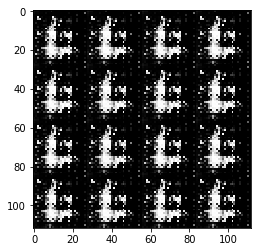

Epoch 2/3... Discriminator Loss: 0.0496... Generator Loss: 3.5308


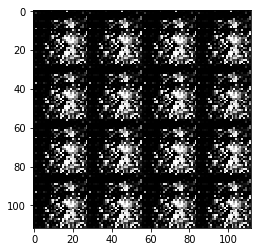

Epoch 2/3... Discriminator Loss: 0.0844... Generator Loss: 3.2576


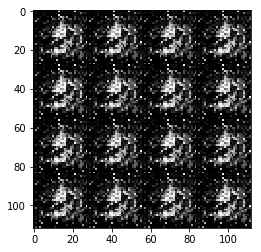

Epoch 2/3... Discriminator Loss: 0.0762... Generator Loss: 2.8548


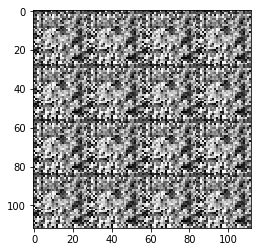

Epoch 3/3... Discriminator Loss: 1.5946... Generator Loss: 0.5611


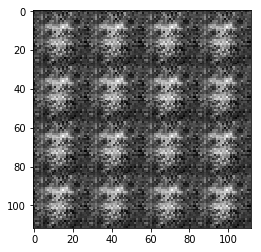

Epoch 3/3... Discriminator Loss: 0.4995... Generator Loss: 1.5474


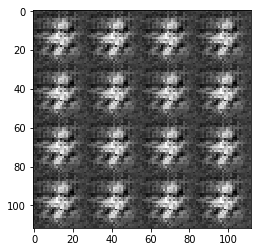

Epoch 3/3... Discriminator Loss: 0.4379... Generator Loss: 1.6843


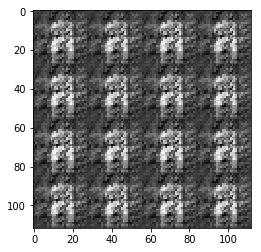

Epoch 3/3... Discriminator Loss: 0.2864... Generator Loss: 2.3150


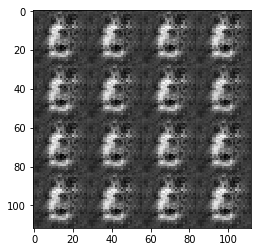

finsihed


In [143]:
batch_size =160
z_dim = 128
learning_rate = 0.0001
beta1 = .5
alpha= .2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 2.5644... Generator Loss: 0.3356


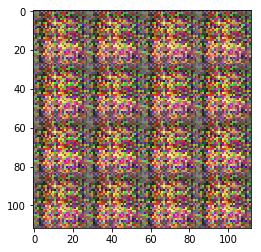

Epoch 1/3... Discriminator Loss: 0.8476... Generator Loss: 1.1397


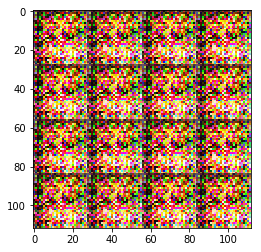

Epoch 1/3... Discriminator Loss: 0.6462... Generator Loss: 1.4170


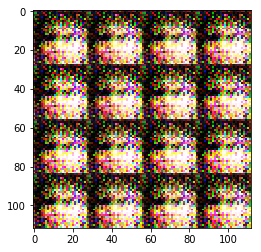

Epoch 1/3... Discriminator Loss: 0.5099... Generator Loss: 1.6445


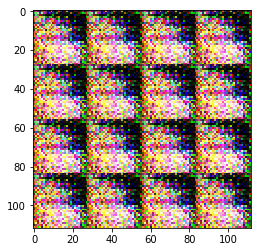

Epoch 1/3... Discriminator Loss: 0.4837... Generator Loss: 1.7918


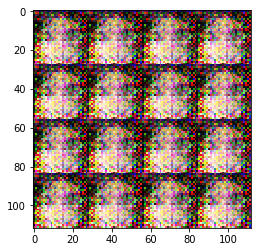

Epoch 1/3... Discriminator Loss: 0.4344... Generator Loss: 1.2608


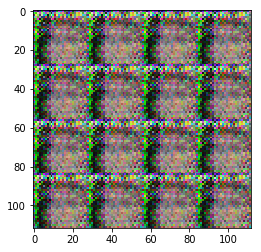

Epoch 1/3... Discriminator Loss: 0.2856... Generator Loss: 2.6357


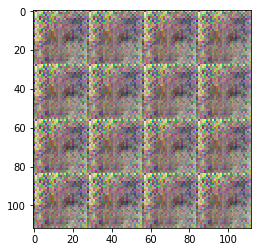

Epoch 1/3... Discriminator Loss: 1.7816... Generator Loss: 0.2317


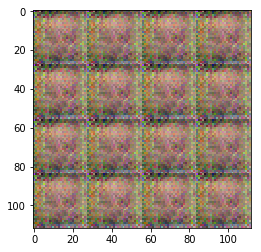

Epoch 1/3... Discriminator Loss: 0.5678... Generator Loss: 1.7014


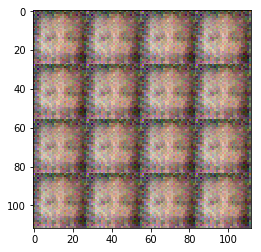

Epoch 1/3... Discriminator Loss: 0.4564... Generator Loss: 1.8889


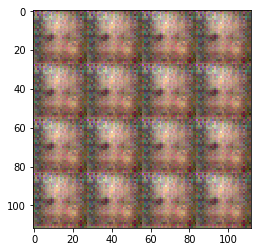

Epoch 1/3... Discriminator Loss: 0.2581... Generator Loss: 2.0852


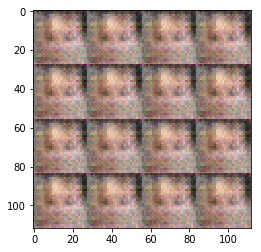

Epoch 1/3... Discriminator Loss: 0.2531... Generator Loss: 2.4033


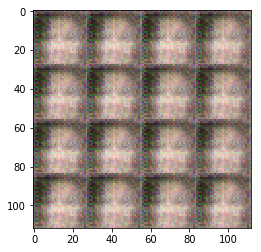

Epoch 1/3... Discriminator Loss: 0.1096... Generator Loss: 3.0875


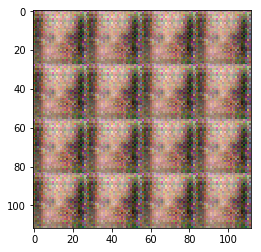

Epoch 1/3... Discriminator Loss: 0.1792... Generator Loss: 2.7483


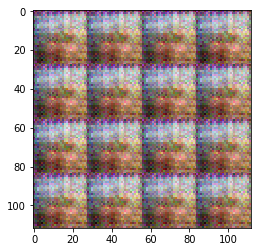

Epoch 2/3... Discriminator Loss: 0.1497... Generator Loss: 2.8235


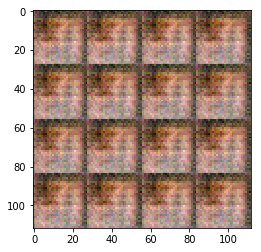

Epoch 2/3... Discriminator Loss: 0.0961... Generator Loss: 3.1603


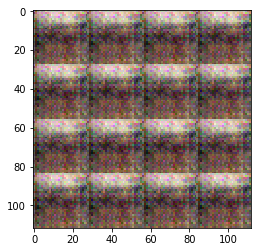

Epoch 2/3... Discriminator Loss: 0.1481... Generator Loss: 2.2004


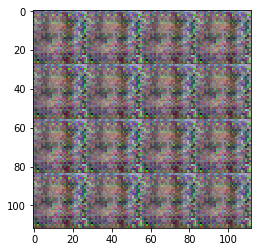

Epoch 2/3... Discriminator Loss: 0.1604... Generator Loss: 2.8764


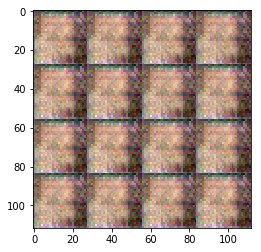

Epoch 2/3... Discriminator Loss: 0.1116... Generator Loss: 3.1101


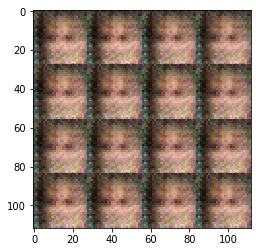

Epoch 2/3... Discriminator Loss: 0.0790... Generator Loss: 3.4778


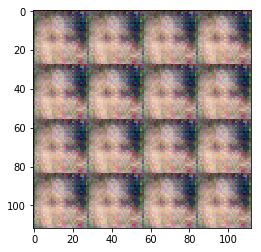

Epoch 2/3... Discriminator Loss: 0.2081... Generator Loss: 2.0500


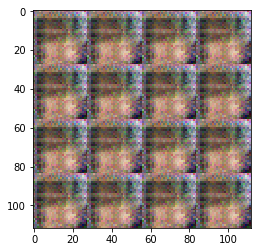

Epoch 2/3... Discriminator Loss: 0.0630... Generator Loss: 3.4219


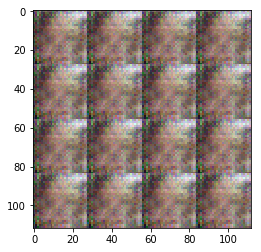

Epoch 2/3... Discriminator Loss: 0.0990... Generator Loss: 3.1424


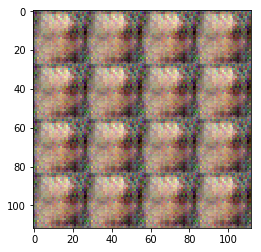

Epoch 2/3... Discriminator Loss: 0.0551... Generator Loss: 3.9795


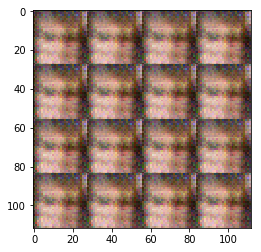

Epoch 2/3... Discriminator Loss: 0.0206... Generator Loss: 4.5077


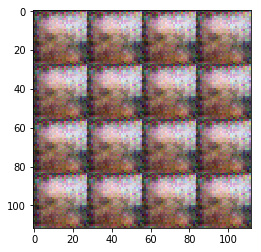

Epoch 2/3... Discriminator Loss: 0.0562... Generator Loss: 3.8708


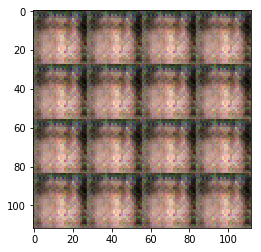

Epoch 2/3... Discriminator Loss: 0.0286... Generator Loss: 4.6281


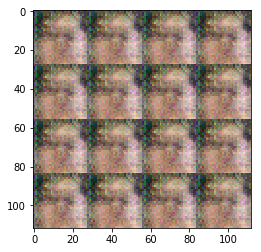

Epoch 2/3... Discriminator Loss: 0.0415... Generator Loss: 3.7075


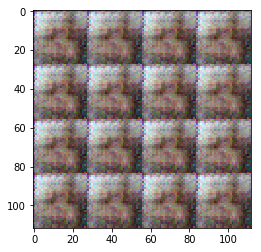

Epoch 3/3... Discriminator Loss: 0.0280... Generator Loss: 4.3547


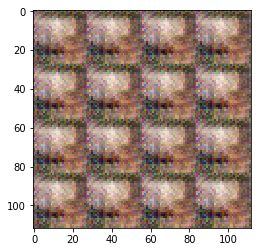

Epoch 3/3... Discriminator Loss: 0.0252... Generator Loss: 4.5826


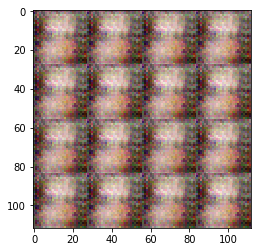

Epoch 3/3... Discriminator Loss: 0.0382... Generator Loss: 3.7339


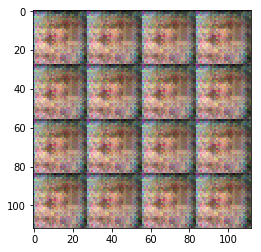

Epoch 3/3... Discriminator Loss: 0.0368... Generator Loss: 3.9645


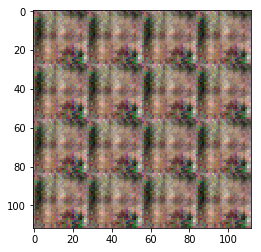

Epoch 3/3... Discriminator Loss: 0.0214... Generator Loss: 4.7200


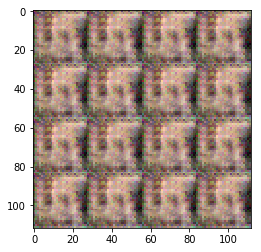

Epoch 3/3... Discriminator Loss: 0.0180... Generator Loss: 4.5078


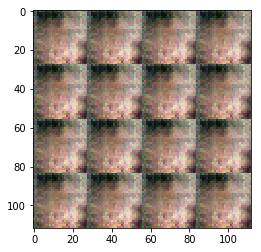

Epoch 3/3... Discriminator Loss: 0.0092... Generator Loss: 5.3477


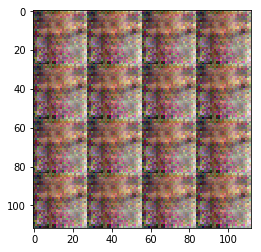

Epoch 3/3... Discriminator Loss: 0.0168... Generator Loss: 4.8330


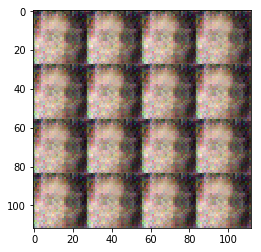

Epoch 3/3... Discriminator Loss: 0.0260... Generator Loss: 4.7466


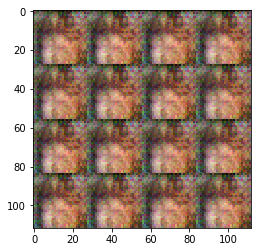

Epoch 3/3... Discriminator Loss: 0.0128... Generator Loss: 5.1522


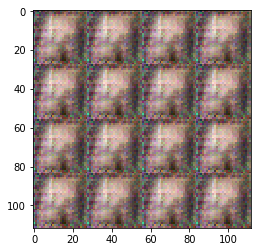

Epoch 3/3... Discriminator Loss: 0.0133... Generator Loss: 4.9163


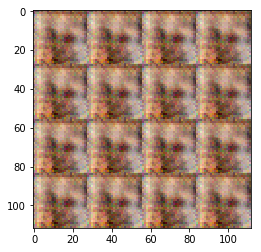

Epoch 3/3... Discriminator Loss: 0.0052... Generator Loss: 5.6378


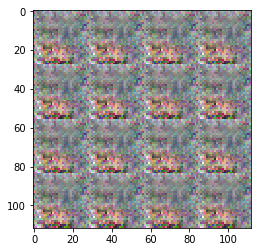

Epoch 3/3... Discriminator Loss: 0.0053... Generator Loss: 5.4526


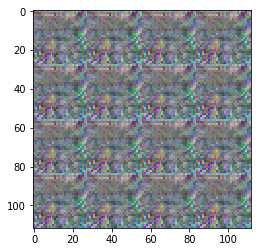

Epoch 3/3... Discriminator Loss: 0.0020... Generator Loss: 6.4204


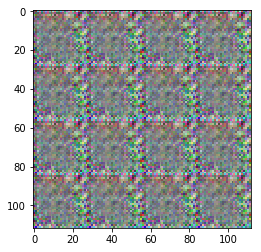

finished


In [144]:
batch_size = 160
z_dim = 128
learning_rate = .0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
    
print('finished')

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.